#### Copyright 2019 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Autoencoders

Autoencoders have been used extensively in image compression and processing. An autoencoder can create higher resolution images from low-res ones, and even colorize black and white images.  It can also denoise images, such as poorly scanned, and even partially damaged and destroyed paper documents ([kaggle dataset](https://www.kaggle.com/c/denoising-dirty-documents)). The materials for the following notebook were found [here](https://github.com/mrdragonbear/Autoencoders/blob/master/Autoencoder-Tutorial.ipynb) and [here](https://www.kaggle.com/vikramtiwari/autoencoders-using-tf-keras-mnist) modified.

Below are additional reading for Autoencoders.

1.   https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368
2.   https://towardsdatascience.com/pca-vs-autoencoders-1ba08362f450
3.   https://www.kaggle.com/abeltadesse/how-autoencoders-work-intro-and-usecases/edit




<a title="Chervinskii [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Autoencoder_structure.png"><img width="512" alt="Autoencoder structure" src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"></a>

[source: Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)


## Overview

### Learning Objectives

* Autoencoders for Compression
* Autoencoder for Denoising


### Prerequisites

* keras
* Visualizations
* opencv

### Estimated Duration

30 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 2 exercises in this Colab so there are 3 points available. The grading scale will be 3 points.

In [0]:
import tensorflow as tf
tf.VERSION

'1.14.0'

In [0]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np


Using TensorFlow backend.


This is a short bash shell script to check if you have downloaded the required data i.e. mnist.npz. If so, it prints out a confirmation message. If not, it downloads the data.

# Download Data

In [0]:
%%bash
FILE=mnist.npz
if test -f "$FILE"; then
  echo "$FILE exists"
else 
  wget -q https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
fi

mnist.npz exists


In [0]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [0]:
(x_train, y_train), (x_test, y_test) = load_data('./mnist.npz')

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Autoencoder Model 1

Below is an example of a simple autoencoder that first maps the 784 dimensional input image to a 32 dimensional latent representation and then attempts to reconstruct the 784 dimensional input image from the 32 dimensional encoded representation. 

In [0]:
latent_dim = 32

## input layer
input_layer = Input(shape=(784,))

## latent view
latent_view   = Dense(latent_dim, activation='relu')(input_layer)

## decoding architecture

## output layer
output_layer  = Dense(784)(latent_view)

autoencoder = Model(input_layer, output_layer)



We can also define the encoder and decoder as individual models 

In [0]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training for 50 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=2048, validation_data=(x_test, x_test), callbacks=[early_stopping])

W0724 16:31:46.578692 140025514198912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0724 16:31:46.668183 140025514198912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.0921 - val_loss: 0.0683
Epoch 2/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0632 - val_loss: 0.0586
Epoch 3/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0532 - val_loss: 0.0470
Epoch 4/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0435 - val_loss: 0.0395
Epoch 5/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0374 - val_loss: 0.0342
Epoch 6/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0330 - val_loss: 0.0310
Epoch 7/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0305 - val_loss: 0.0292
Epoch 8/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0289 - val_loss: 0.0278
Epoch 9/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0276 - val_loss: 0.0266
Epoch 10/50
6

In [0]:
decoded_imgs = autoencoder.predict(x_test)

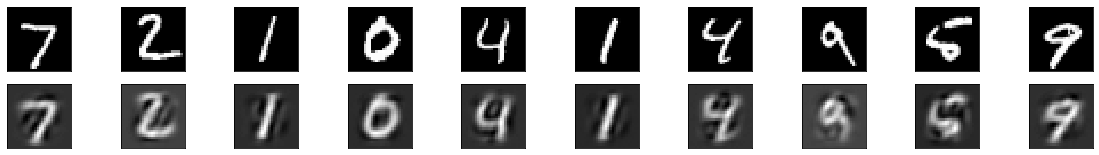

In [0]:
# using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Applications

There are many applications to autoencoders.

## Image Compression

To see how autoencoders can be used to compress images, we will need to define the encoder and decoder halves of the autoencoder as individual models.

In [0]:
latent_dim = 36

inputs = Input(shape=(784,), name='encoder_input')
latent_view = Dense(latent_dim, name='latent_vector')(inputs)

# Instantiate Encoder Model
encoder = Model(inputs, latent_view, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
decoded = Dense(784)(latent_inputs)

# Instantiate Decoder Model
decoder = Model(latent_inputs, decoded, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
latent_vector (Dense)        (None, 36)                28260     
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               29008     
Total params: 29,008
Trainable params: 29,008
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
La

In [0]:
# Training for 50 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=2048, validation_data=(x_test, x_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.0858 - val_loss: 0.0623
Epoch 2/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0560 - val_loss: 0.0486
Epoch 3/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0436 - val_loss: 0.0386
Epoch 4/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0364 - val_loss: 0.0334
Epoch 5/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0318 - val_loss: 0.0295
Epoch 6/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0283 - val_loss: 0.0264
Epoch 7/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0256 - val_loss: 0.0241
Epoch 8/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0236 - val_loss: 0.0223
Epoch 9/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.0221 - val_loss: 0.0210
Epoch 10/50
6

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

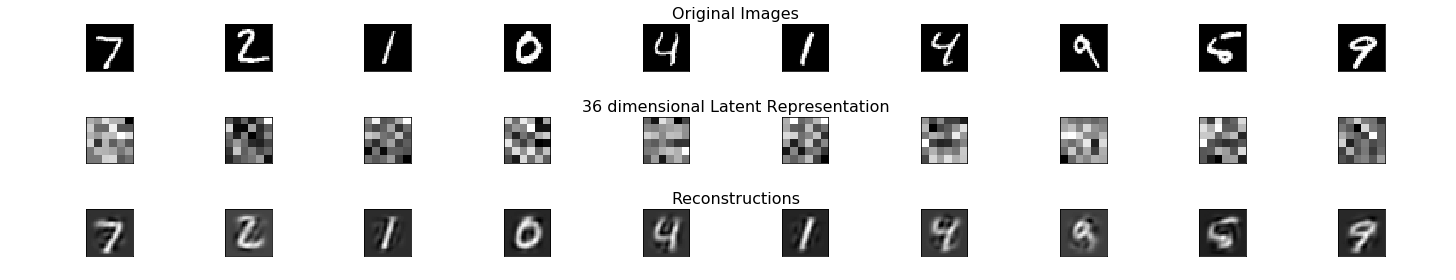

In [0]:
n = 10 # how many images we will display
#plt.figure(figsize=(20, 4))
fig, axes = plt.subplots( figsize=(20,4) , nrows=3, ncols=1, sharey=False) 
axes[0].set_title('Original Images', fontsize=16)
axes[0].axis('off')
axes[1].set_title('36 dimensional Latent Representation', fontsize=16)
axes[1].axis('off')
axes[2].set_title('Reconstructions', fontsize=16)
axes[2].axis('off')


for i in range(n):
    # display original
    ax = fig.add_subplot(3, n, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
    
    
    # display encoding
    ax = fig.add_subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(6, 6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = fig.add_subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig.tight_layout()
plt.show()

## Denoising

In [0]:
# Reshape the train and test array for augmenter
x_train = x_train.reshape(-1, 28, 28, 1)  # becomes of shape (60000, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)    # becomes of shape (10000, 28, 28, 1)
  
noise = augmenters.SaltAndPepper(0.6)
seq_object = augmenters.Sequential([noise])

x_train_n = seq_object.augment_images(x_train * 255) / 255
x_test_n = seq_object.augment_images(x_test * 255) / 255

Before we add noise, the images look like this.

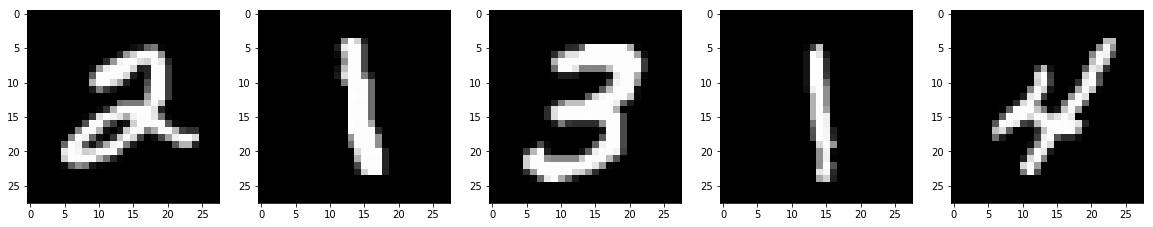

In [0]:
f, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols=5)
for i in range(5,10):
    ax[i-5].imshow(x_train[i].reshape(28, 28))
plt.show()

After we add noise, the images look like this.

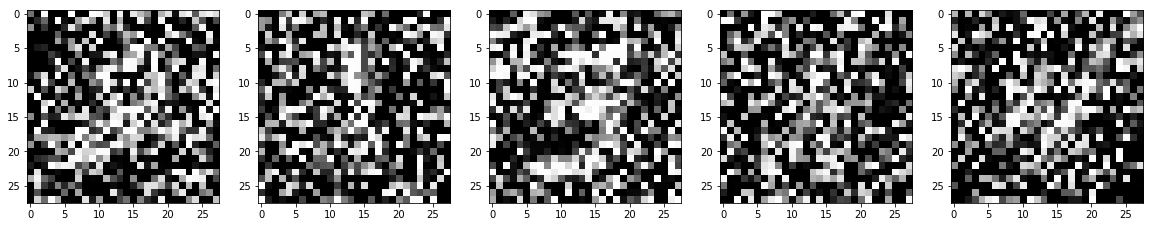

In [0]:
f, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols=5)
for i in range(5,10):
    ax[i-5].imshow(x_train_n[i].reshape(28, 28))
plt.show()

For our denoising autoencoder, we will need a more sophisticated architecture of Conv2D and MaxPool2D layers.

## Autoencoder Model 2

In [0]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
denoise_autoencoder = Model(input_layer, output_layer)
denoise_autoencoder.compile(optimizer='adam', loss='mse')

In [0]:
denoise_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 16)          0         
__________

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = denoise_autoencoder.fit(x_train_n, x_train, epochs=10, batch_size=2048, validation_data=(x_test_n, x_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.0724 - val_loss: 0.0657
Epoch 2/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0619 - val_loss: 0.0578
Epoch 3/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0555 - val_loss: 0.0528
Epoch 4/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0508 - val_loss: 0.0483
Epoch 5/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0473 - val_loss: 0.0454
Epoch 6/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0445 - val_loss: 0.0434
Epoch 7/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0424 - val_loss: 0.0413
Epoch 8/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0406 - val_loss: 0.0395
Epoch 9/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0392 - val_loss: 0.0

In [0]:
preds = denoise_autoencoder.predict(x_test_n[:10])

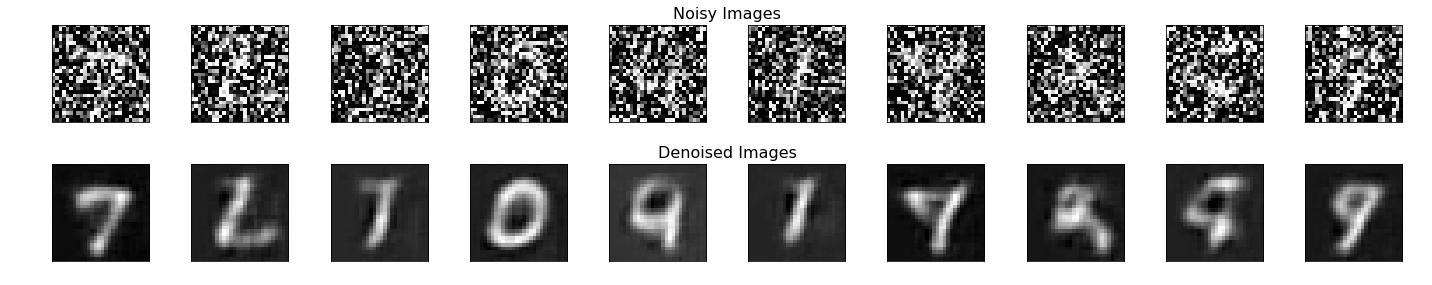

In [0]:
n = 10 # how many images we will display
fig, axes = plt.subplots( figsize=(20,4) , nrows=2, ncols=1, sharey=False) 
axes[0].set_title('Noisy Images', fontsize=16)
axes[0].axis('off')
axes[1].set_title('Denoised Images', fontsize=16)
axes[1].axis('off')



for i in range(n):
    # display noisy images
    ax = fig.add_subplot(2, n, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_n[i].reshape(28, 28))
    plt.gray()
    
    # display denoised images
    ax = fig.add_subplot(2, n, i + 1 + n)
    plt.imshow(preds[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

# Exercise 1

On the MNIST dataset used above, 

1.   Use the second more sophisticated autoencoder model for compression. Try to get the autoencoder's output to have the same quality as the original images. 
2.   Try different values for the latent (encoding) dimension to find the smallest latent dimension from which we can reconstruct a visible (not necessarily the best quality ) version of the original images.



# Exercise 2

Using the second autoencoder model defined above, 


1.   Try bigger values for the SaltAndPepper augmenter to generate significantly noisier images and see how noisy the images can get and still be denoised.
2.   Try using other kinds of noise in place of ***SaltAndPepper***  such as ***Salt***, ***Pepper***,	***CoarseSaltAndPepper*** and 	***CoarseSalt***. Then, use the denoising autoenconder defined above to denoise your noisy images. Note that some of these augmentations (noises) are much harder than others to denoise. Feel free to randomly generate your own noise using numpy.

